In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from gensim.models import KeyedVectors
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
import time
import math

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

In [3]:
# Load dataset
data_path = '/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv'
data = pd.read_csv(data_path)
print(data.head())

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


In [5]:
# Preprocessing: Text Cleaning, Tokenization, and Normalization
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

# Create sentiment labels from ratings
def rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

data['Sentiment'] = data['Rating'].apply(rating_to_sentiment)

# Convert 'Sentiment' column to category
data['Sentiment'] = data['Sentiment'].astype('category')
print(data.head())

                                              Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      Cleaned_Review Sentiment  
0  nice hotel expensive parking got good deal sta...  positive  
1  ok nothing special charge diamond member hilto...  negative  
2  nice room experience hotel monaco seattle good...   neutral  
3  unique great stay wonderful time hotel monaco ...  positive  
4  great stay great stay went seahawk game awesom...  positive  


In [6]:
# Load FastText model
fasttext_model_path = '/kaggle/input/fasttext-wikinews/wiki-news-300d-1M.vec'
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

# Convert text data to FastText vectors (average of word vectors)
def fasttext_text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [fasttext_model[word] for word in tokens if word in fasttext_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

fasttext_vectors = np.array([fasttext_text_to_vector(text) for text in data['Cleaned_Review']])

# Normalize vectors
normalized_fasttext_vectors = normalize(fasttext_vectors, axis=1)


In [7]:
# Prepare sentences for Word2Vec
sentences = [nltk.word_tokenize(text) for text in data['Cleaned_Review']]

# Train Word2Vec model
cores = multiprocessing.cpu_count()
word2vec_model = Word2Vec(min_count=20,
                          window=2,
                          vector_size=300,
                          sample=6e-5,
                          alpha=0.03,
                          min_alpha=0.0007,
                          negative=20,
                          workers=cores-1)

t = time.time()
word2vec_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

t = time.time()
word2vec_model.train(sentences, total_examples=word2vec_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

# Convert text data to Word2Vec vectors (average of word vectors)
def word2vec_text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

word2vec_vectors = np.array([word2vec_text_to_vector(text) for text in data['Cleaned_Review']])

# Normalize vectors
normalized_word2vec_vectors = normalize(word2vec_vectors, axis=1)


Time to build vocab: 0.01 mins
Time to train the model: 1.35 mins


In [8]:
# Convert text data to TaggedDocuments for Doc2Vec
documents = [TaggedDocument(nltk.word_tokenize(text.lower()), [i]) for i, text in enumerate(data['Cleaned_Review'])]

# Train Doc2Vec model
num_cores_doc2vec = multiprocessing.cpu_count()
doc2vec_model = Doc2Vec(vector_size=300,
                        window=2,
                        min_count=2,
                        workers=num_cores_doc2vec-1,
                        epochs=40)

t = time.time()
doc2vec_model.build_vocab(documents)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

t = time.time()
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

# Convert text data to Doc2Vec vectors
def convert_text_to_doc2vec_vector(text):
    return doc2vec_model.infer_vector(nltk.word_tokenize(text.lower()), alpha=0.1, min_alpha=0.0001)

doc2vec_vectors = np.array([convert_text_to_doc2vec_vector(text) for text in data['Cleaned_Review']])

# Normalize Doc2Vec vectors
normalized_doc2vec_vectors = normalize(doc2vec_vectors, axis=1)

Time to build vocab: 0.02 mins
Time to train the model: 2.8 mins


In [9]:
# Define LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add dimension for seq_length
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output


In [10]:
# Define BiLSTM model
class SentimentBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(SentimentBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # hidden_size * 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add dimension for seq_length
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # * 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # * 2 for bidirectional
        bilstm_out, _ = self.bilstm(x, (h0, c0))
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out[:, -1, :]
        output = self.fc(bilstm_out)
        return output


In [11]:
# Define Attention mechanism
class Attention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim):
        super(Attention, self).__init__()
        self.scale = 1. / math.sqrt(query_dim)

    def forward(self, query, keys, values):
        query = query.unsqueeze(1)  # [B, hidden_size * 2] -> [B, 1, hidden_size * 2]
        keys = keys.permute(0, 2, 1)  # [B, T, hidden_size * 2] -> [B, hidden_size * 2, T]
        energy = torch.bmm(query, keys)  # [B, 1, hidden_size * 2] x [B, hidden_size * 2, T] -> [B, 1, T]
        energy = torch.nn.functional.softmax(energy.mul_(self.scale), dim=2)  # scale, normalize

        linear_combination = torch.bmm(energy, values).squeeze(1)  # [B, 1, T] x [B, T, hidden_size * 2] -> [B, hidden_size * 2]
        return energy, linear_combination

# Define BiLSTM with Attention model
class SentimentBiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(SentimentBiLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size * 2, hidden_size * 2, hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # hidden_size * 2 for bidirectional

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, input_size] -> [B, 1, input_size]
        bilstm_out, (hn, cn) = self.bilstm(x)
        bilstm_out = bilstm_out.contiguous()  # Ensure the tensor is contiguous
        query = hn.transpose(0, 1).contiguous().view(x.size(0), -1)
        keys = bilstm_out
        values = bilstm_out
        energy, linear_combination = self.attention(query, keys, values)
        output = self.fc(linear_combination)
        return output



Using device: cuda

Running cross-validation for LSTM with FASTTEXT embeddings
Epoch 1/20, Loss: 0.6317, Accuracy: 0.7201
Epoch 2/20, Loss: 0.5533, Accuracy: 0.7672
Epoch 3/20, Loss: 0.5374, Accuracy: 0.7736
Epoch 4/20, Loss: 0.5250, Accuracy: 0.7795
Epoch 5/20, Loss: 0.5145, Accuracy: 0.7836
Epoch 6/20, Loss: 0.5080, Accuracy: 0.7865
Epoch 7/20, Loss: 0.4987, Accuracy: 0.7914
Epoch 8/20, Loss: 0.4943, Accuracy: 0.7918
Epoch 9/20, Loss: 0.4855, Accuracy: 0.7973
Epoch 10/20, Loss: 0.4786, Accuracy: 0.8009
Epoch 11/20, Loss: 0.4682, Accuracy: 0.8073
Epoch 12/20, Loss: 0.4623, Accuracy: 0.8084
Epoch 13/20, Loss: 0.4559, Accuracy: 0.8122
Epoch 14/20, Loss: 0.4460, Accuracy: 0.8159
Epoch 15/20, Loss: 0.4394, Accuracy: 0.8184
Epoch 16/20, Loss: 0.4305, Accuracy: 0.8227
Epoch 17/20, Loss: 0.4240, Accuracy: 0.8268
Epoch 18/20, Loss: 0.4149, Accuracy: 0.8322
Epoch 19/20, Loss: 0.4044, Accuracy: 0.8365
Epoch 20/20, Loss: 0.3963, Accuracy: 0.8409
Validation 1/5, Validation Accuracy: 0.7236

Epoc

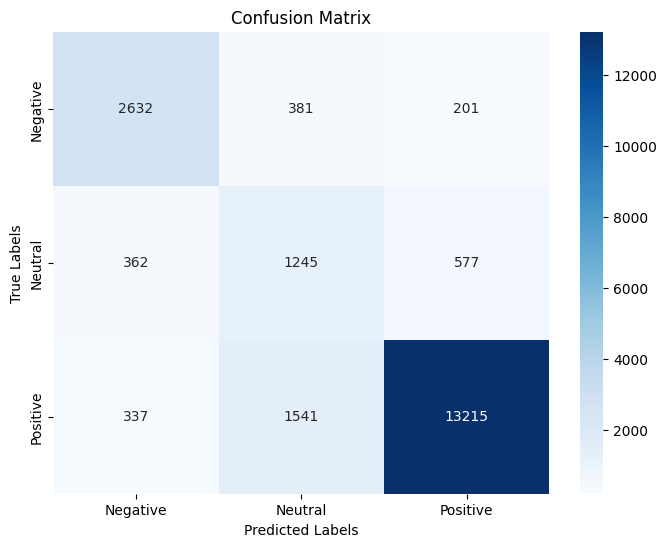


Running cross-validation for LSTM with WORD2VEC embeddings
Epoch 1/20, Loss: 0.5585, Accuracy: 0.7588
Epoch 2/20, Loss: 0.4963, Accuracy: 0.7917
Epoch 3/20, Loss: 0.4736, Accuracy: 0.8024
Epoch 4/20, Loss: 0.4516, Accuracy: 0.8123
Epoch 5/20, Loss: 0.4230, Accuracy: 0.8258
Epoch 6/20, Loss: 0.3966, Accuracy: 0.8380
Epoch 7/20, Loss: 0.3677, Accuracy: 0.8521
Epoch 8/20, Loss: 0.3423, Accuracy: 0.8633
Epoch 9/20, Loss: 0.3171, Accuracy: 0.8773
Epoch 10/20, Loss: 0.2939, Accuracy: 0.8868
Epoch 11/20, Loss: 0.2691, Accuracy: 0.8958
Epoch 12/20, Loss: 0.2454, Accuracy: 0.9086
Epoch 13/20, Loss: 0.2293, Accuracy: 0.9153
Epoch 14/20, Loss: 0.2112, Accuracy: 0.9219
Epoch 15/20, Loss: 0.1957, Accuracy: 0.9288
Epoch 16/20, Loss: 0.1784, Accuracy: 0.9357
Epoch 17/20, Loss: 0.1694, Accuracy: 0.9384
Epoch 18/20, Loss: 0.1574, Accuracy: 0.9434
Epoch 19/20, Loss: 0.1494, Accuracy: 0.9454
Epoch 20/20, Loss: 0.1401, Accuracy: 0.9485
Validation 1/5, Validation Accuracy: 0.7790

Epoch 1/20, Loss: 0.5607

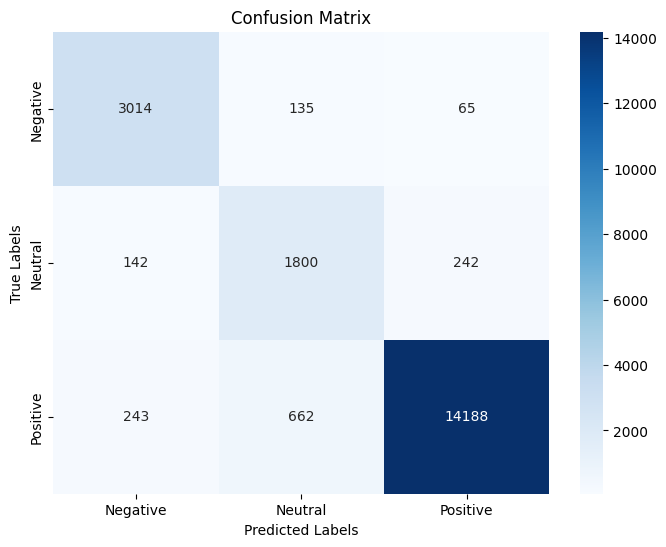


Running cross-validation for LSTM with DOC2VEC embeddings
Epoch 1/20, Loss: 0.5438, Accuracy: 0.7690
Epoch 2/20, Loss: 0.4776, Accuracy: 0.8009
Epoch 3/20, Loss: 0.4400, Accuracy: 0.8156
Epoch 4/20, Loss: 0.3872, Accuracy: 0.8407
Epoch 5/20, Loss: 0.3147, Accuracy: 0.8769
Epoch 6/20, Loss: 0.2366, Accuracy: 0.9113
Epoch 7/20, Loss: 0.1772, Accuracy: 0.9376
Epoch 8/20, Loss: 0.1345, Accuracy: 0.9519
Epoch 9/20, Loss: 0.1046, Accuracy: 0.9628
Epoch 10/20, Loss: 0.0848, Accuracy: 0.9701
Epoch 11/20, Loss: 0.0683, Accuracy: 0.9764
Epoch 12/20, Loss: 0.0586, Accuracy: 0.9792
Epoch 13/20, Loss: 0.0520, Accuracy: 0.9819
Epoch 14/20, Loss: 0.0448, Accuracy: 0.9848
Epoch 15/20, Loss: 0.0381, Accuracy: 0.9863
Epoch 16/20, Loss: 0.0357, Accuracy: 0.9876
Epoch 17/20, Loss: 0.0320, Accuracy: 0.9897
Epoch 18/20, Loss: 0.0300, Accuracy: 0.9897
Epoch 19/20, Loss: 0.0293, Accuracy: 0.9898
Epoch 20/20, Loss: 0.0270, Accuracy: 0.9911
Validation 1/5, Validation Accuracy: 0.8234

Epoch 1/20, Loss: 0.5333,

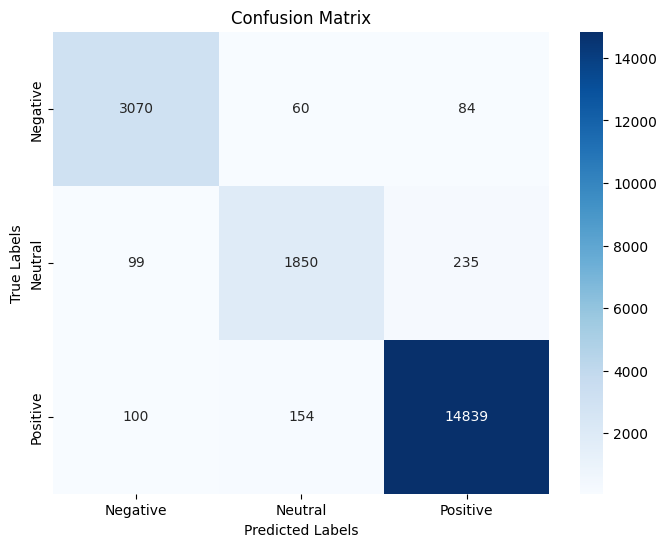

In [1]:
# Check if GPU is available
print(f'Using device: {device}')

# Cross-validation and hyperparameter tuning for LSTM
def cross_validate_and_tune_lstm(vectors, labels, num_folds=5, num_epochs=20):
    skf = StratifiedKFold(n_splits=num_folds)
    best_model = None
    best_acc = 0.0

    for num_evaluation, (train_index, val_index) in enumerate(skf.split(vectors, labels)):
        X_train, X_val = vectors[train_index], vectors[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Apply SMOTE to the training data
        smote = SMOTE(sampling_strategy='auto', random_state=42)  
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(pd.Categorical(y_train_smote).codes, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(pd.Categorical(y_val).codes, dtype=torch.long).to(device)

        # Define parameters
        input_size = 300  # Size of word vectors (FastText, Word2Vec, Doc2Vec)
        hidden_size = 128
        output_size = len(set(labels))
        num_layers = 2
        dropout = 0.3

        # Calculate class weights
        class_counts = Counter(y_train_smote)
        total_samples = len(y_train_smote)
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(device)

        # Create LSTM model instance
        lstm_model = SentimentLSTM(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout).to(device)

        # Define optimizer and loss function
        optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

        # Define DataLoader
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

        # Training loop
        def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct_predictions = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    correct_predictions += (predicted == labels).sum().item()

                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_acc = correct_predictions / len(train_loader.dataset)
                print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            return model

        # Train the model
        trained_model = train_model(lstm_model, train_loader, optimizer, loss_fn, num_epochs)

        # Evaluate the model
        def evaluate_model(model, X_val_tensor, y_val_tensor):
            model.eval()
            with torch.no_grad():
                outputs = model(X_val_tensor)
                _, predicted = torch.max(outputs, 1)
                acc = (predicted == y_val_tensor).sum().item() / len(y_val_tensor)
                cm = confusion_matrix(y_val_tensor.cpu(), predicted.cpu())
                cr = classification_report(y_val_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
            return acc, cm, cr

        val_acc, val_cm, val_cr = evaluate_model(trained_model, X_val_tensor, y_val_tensor)
        print(f'Validation {num_evaluation + 1}/{num_folds}, Validation Accuracy: {val_acc:.4f} \n')
        

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = trained_model

    return best_model, best_acc

# Final evaluation function
def final_evaluation(model, test_vectors_tensor, test_labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(test_vectors_tensor)
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == test_labels_tensor).sum().item() / len(test_labels_tensor)
        cm = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
        cr = classification_report(test_labels_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
    return acc, cm, cr

# Main execution for different word embeddings
labels = data['Sentiment'].values
vector_types = ["fasttext", "word2vec", "doc2vec"]

for vector_type in vector_types:
    print(f"\nRunning cross-validation for LSTM with {vector_type.upper()} embeddings")
    
    if vector_type == "fasttext":
        vectors = normalized_fasttext_vectors
    elif vector_type == "word2vec":
        vectors = normalized_word2vec_vectors
    elif vector_type == "doc2vec":
        vectors = normalized_doc2vec_vectors

    best_model, best_acc = cross_validate_and_tune_lstm(vectors=vectors, labels=labels, num_folds=5, num_epochs=20)
    print(f'Best LSTM model accuracy with {vector_type.upper()} embeddings: {best_acc:.4f}')

    # Convert test data to tensors
    test_vectors_tensor = torch.tensor(vectors, dtype=torch.float32).to(device)
    test_labels_tensor = torch.tensor(pd.Categorical(labels).codes, dtype=torch.long).to(device)

    # Final evaluation on test set
    final_acc, final_cm, final_cr = final_evaluation(best_model, test_vectors_tensor, test_labels_tensor)
    print(f"Final Test Accuracy: {final_acc:.4f}")
    print("Final Confusion Matrix:")
    print(final_cm)
    print("\nFinal Classification Report:")
    print(final_cr)

    # Define confusion_matrix
    def plot_confusion_matrix(cm, labels):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(final_cm, ['negative', 'neutral', 'positive'])


Using device: cuda

Running cross-validation for BiLSTM with FASTTEXT embeddings
Epoch 1/20, Loss: 0.6162, Accuracy: 0.7291
Epoch 2/20, Loss: 0.5461, Accuracy: 0.7705
Epoch 3/20, Loss: 0.5280, Accuracy: 0.7796
Epoch 4/20, Loss: 0.5161, Accuracy: 0.7830
Epoch 5/20, Loss: 0.5036, Accuracy: 0.7888
Epoch 6/20, Loss: 0.4971, Accuracy: 0.7930
Epoch 7/20, Loss: 0.4876, Accuracy: 0.7969
Epoch 8/20, Loss: 0.4760, Accuracy: 0.8013
Epoch 9/20, Loss: 0.4627, Accuracy: 0.8060
Epoch 10/20, Loss: 0.4501, Accuracy: 0.8124
Epoch 11/20, Loss: 0.4398, Accuracy: 0.8198
Epoch 12/20, Loss: 0.4298, Accuracy: 0.8224
Epoch 13/20, Loss: 0.4170, Accuracy: 0.8288
Epoch 14/20, Loss: 0.4033, Accuracy: 0.8360
Epoch 15/20, Loss: 0.3929, Accuracy: 0.8401
Epoch 16/20, Loss: 0.3785, Accuracy: 0.8484
Epoch 17/20, Loss: 0.3632, Accuracy: 0.8574
Epoch 18/20, Loss: 0.3496, Accuracy: 0.8623
Epoch 19/20, Loss: 0.3357, Accuracy: 0.8684
Epoch 20/20, Loss: 0.3211, Accuracy: 0.8738
Validation 1/5, Validation Accuracy: 0.7634 

E

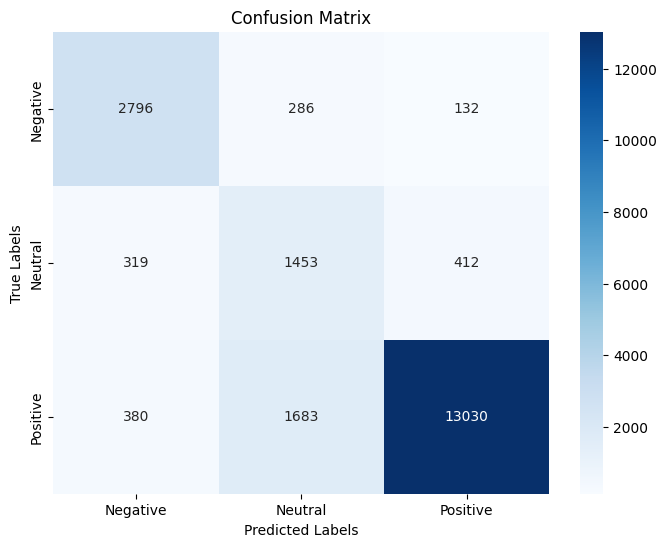


Running cross-validation for BiLSTM with WORD2VEC embeddings
Epoch 1/20, Loss: 0.5443, Accuracy: 0.7674
Epoch 2/20, Loss: 0.4850, Accuracy: 0.7972
Epoch 3/20, Loss: 0.4529, Accuracy: 0.8109
Epoch 4/20, Loss: 0.4195, Accuracy: 0.8278
Epoch 5/20, Loss: 0.3847, Accuracy: 0.8425
Epoch 6/20, Loss: 0.3443, Accuracy: 0.8616
Epoch 7/20, Loss: 0.3032, Accuracy: 0.8823
Epoch 8/20, Loss: 0.2704, Accuracy: 0.8966
Epoch 9/20, Loss: 0.2362, Accuracy: 0.9107
Epoch 10/20, Loss: 0.2059, Accuracy: 0.9230
Epoch 11/20, Loss: 0.1831, Accuracy: 0.9331
Epoch 12/20, Loss: 0.1603, Accuracy: 0.9417
Epoch 13/20, Loss: 0.1426, Accuracy: 0.9477
Epoch 14/20, Loss: 0.1244, Accuracy: 0.9560
Epoch 15/20, Loss: 0.1125, Accuracy: 0.9593
Epoch 16/20, Loss: 0.1036, Accuracy: 0.9629
Epoch 17/20, Loss: 0.0907, Accuracy: 0.9690
Epoch 18/20, Loss: 0.0829, Accuracy: 0.9703
Epoch 19/20, Loss: 0.0740, Accuracy: 0.9746
Epoch 20/20, Loss: 0.0678, Accuracy: 0.9760
Validation 1/5, Validation Accuracy: 0.7943

Epoch 1/20, Loss: 0.54

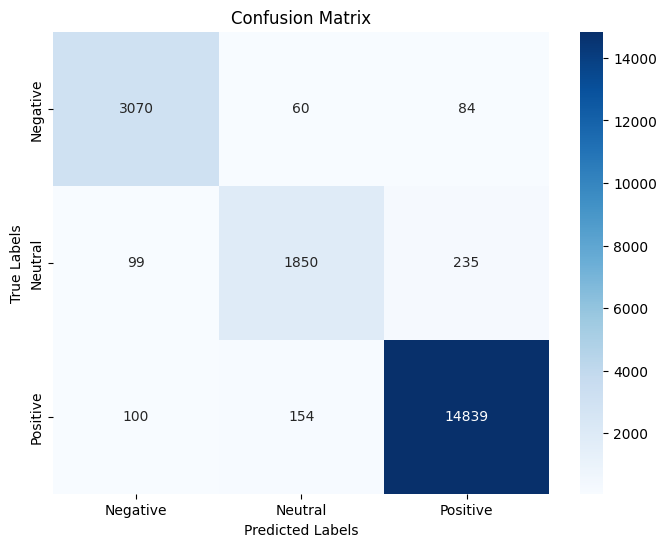


Running cross-validation for BiLSTM with DOC2VEC embeddings
Epoch 1/20, Loss: 0.5285, Accuracy: 0.7771
Epoch 2/20, Loss: 0.4609, Accuracy: 0.8056
Epoch 3/20, Loss: 0.4038, Accuracy: 0.8336
Epoch 4/20, Loss: 0.3201, Accuracy: 0.8734
Epoch 5/20, Loss: 0.2230, Accuracy: 0.9179
Epoch 6/20, Loss: 0.1435, Accuracy: 0.9497
Epoch 7/20, Loss: 0.0951, Accuracy: 0.9665
Epoch 8/20, Loss: 0.0627, Accuracy: 0.9782
Epoch 9/20, Loss: 0.0439, Accuracy: 0.9851
Epoch 10/20, Loss: 0.0348, Accuracy: 0.9878
Epoch 11/20, Loss: 0.0261, Accuracy: 0.9911
Epoch 12/20, Loss: 0.0205, Accuracy: 0.9930
Epoch 13/20, Loss: 0.0201, Accuracy: 0.9931
Epoch 14/20, Loss: 0.0148, Accuracy: 0.9946
Epoch 15/20, Loss: 0.0161, Accuracy: 0.9946
Epoch 16/20, Loss: 0.0139, Accuracy: 0.9951
Epoch 17/20, Loss: 0.0111, Accuracy: 0.9965
Epoch 18/20, Loss: 0.0123, Accuracy: 0.9958
Epoch 19/20, Loss: 0.0095, Accuracy: 0.9969
Epoch 20/20, Loss: 0.0095, Accuracy: 0.9966

Validation 1/5, Validation Accuracy: 0.7963
Epoch 1/20, Loss: 0.522

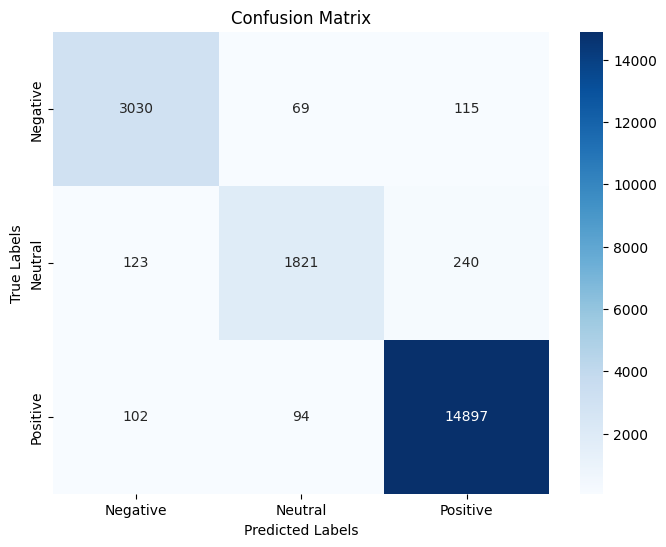

In [2]:
# Check if GPU is available
print(f'Using device: {device}')

# Cross-validation and hyperparameter tuning for BiLSTM
def cross_validate_and_tune(vectors, labels, model_type='bilstm', num_folds=5, num_epochs=20):
    skf = StratifiedKFold(n_splits=num_folds)
    best_model = None
    best_acc = 0.0
    
    for num_evaluation, (train_index, val_index) in enumerate(skf.split(vectors, labels)):
        X_train, X_val = vectors[train_index], vectors[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Apply SMOTE to the training data
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(pd.Categorical(y_train_smote).codes, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(pd.Categorical(y_val).codes, dtype=torch.long).to(device)

        # Define parameters
        input_size = X_train_tensor.shape[1]  # Size of embedding vectors (e.g., 300 for FastText)
        hidden_size = 128
        output_size = len(np.unique(y_train_smote))  # Number of classes
        num_layers = 2
        dropout = 0.3

        # Calculate class weights
        class_counts = Counter(y_train_smote)
        total_samples = len(y_train_smote)
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(device)

        # Create BiLSTM model instance
        if model_type == 'bilstm':
            model = SentimentBiLSTM(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout).to(device)
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        # Define optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

        # Define DataLoader
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

        # Training loop
        def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct_predictions = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    correct_predictions += (predicted == labels).sum().item()

                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_acc = correct_predictions / len(train_loader.dataset)
                print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            return model

        # Train the model
        trained_model = train_model(model, train_loader, optimizer, loss_fn, num_epochs)

        # Evaluate the model
        def evaluate_model(model, X_val_tensor, y_val_tensor):
            model.eval()
            with torch.no_grad():
                outputs = model(X_val_tensor)
                _, predicted = torch.max(outputs, 1)
                acc = (predicted == y_val_tensor).sum().item() / len(y_val_tensor)
                cm = confusion_matrix(y_val_tensor.cpu(), predicted.cpu())
                cr = classification_report(y_val_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
            return acc, cm, cr

        val_acc, val_cm, val_cr = evaluate_model(trained_model, X_val_tensor, y_val_tensor)
        print(f'Validation {num_evaluation + 1}/{num_folds}, Validation Accuracy: {val_acc:.4f} \n')
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = trained_model
            
    return best_model, best_acc


# Define final evaluation function
def final_evaluation(model, test_vectors_tensor, test_labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(test_vectors_tensor)
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == test_labels_tensor).sum().item() / len(test_labels_tensor)
        cm = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
        cr = classification_report(test_labels_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
    return acc, cm, cr

# Cross-validation and hyperparameter tuning for BiLSTM
labels = data['Sentiment'].values
vector_types = ["fasttext", "word2vec", "doc2vec"]

for vector_type in vector_types:
    print(f"\nRunning cross-validation for BiLSTM with {vector_type.upper()} embeddings")
    
    if vector_type == "fasttext":
        vectors = normalized_fasttext_vectors
    elif vector_type == "word2vec":
        vectors = normalized_word2vec_vectors
    elif vector_type == "doc2vec":
        vectors = normalized_doc2vec_vectors

    best_model, best_acc = cross_validate_and_tune(vectors=vectors, labels=labels, model_type='bilstm', num_folds=5, num_epochs=20)
    print(f'Best BiLSTM model accuracy with {vector_type.upper()} embeddings: {best_acc:.4f}')
    
    # Convert test data to tensors (misalkan test_vectors sudah disediakan)
    test_vectors_tensor = torch.tensor(vectors, dtype=torch.float32).to(device)
    test_labels_tensor = torch.tensor(pd.Categorical(labels).codes, dtype=torch.long).to(device)

    # Final evaluation on test set
    final_acc, final_cm, final_cr = final_evaluation(best_model, test_vectors_tensor, test_labels_tensor)
    print(f"Final Test Accuracy: {final_acc:.4f}")
    print("Final Confusion Matrix:")
    print(final_cm)
    print("\nFinal Classification Report:")
    print(final_cr)
    
    # Confusion Matrix Visualization
    def plot_confusion_matrix(cm, labels):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
    
    plot_confusion_matrix(final_cm, ['negative', 'neutral', 'positive'])


Using device: cuda

Running cross-validation for BiLSTM-Attention with FASTTEXT embeddings
Epoch 1/20, Loss: 0.6117, Accuracy: 0.7340
Epoch 2/20, Loss: 0.5440, Accuracy: 0.7722
Epoch 3/20, Loss: 0.5296, Accuracy: 0.7803
Epoch 4/20, Loss: 0.5211, Accuracy: 0.7842
Epoch 5/20, Loss: 0.5126, Accuracy: 0.7851
Epoch 6/20, Loss: 0.5021, Accuracy: 0.7919
Epoch 7/20, Loss: 0.4945, Accuracy: 0.7952
Epoch 8/20, Loss: 0.4855, Accuracy: 0.7988
Epoch 9/20, Loss: 0.4769, Accuracy: 0.8028
Epoch 10/20, Loss: 0.4661, Accuracy: 0.8095
Epoch 11/20, Loss: 0.4566, Accuracy: 0.8148
Epoch 12/20, Loss: 0.4454, Accuracy: 0.8190
Epoch 13/20, Loss: 0.4355, Accuracy: 0.8252
Epoch 14/20, Loss: 0.4235, Accuracy: 0.8314
Epoch 15/20, Loss: 0.4129, Accuracy: 0.8358
Epoch 16/20, Loss: 0.4017, Accuracy: 0.8430
Epoch 17/20, Loss: 0.3888, Accuracy: 0.8467
Epoch 18/20, Loss: 0.3796, Accuracy: 0.8536
Epoch 19/20, Loss: 0.3680, Accuracy: 0.8594
Epoch 20/20, Loss: 0.3567, Accuracy: 0.8645
Validation 1/5, Validation Accuracy: 

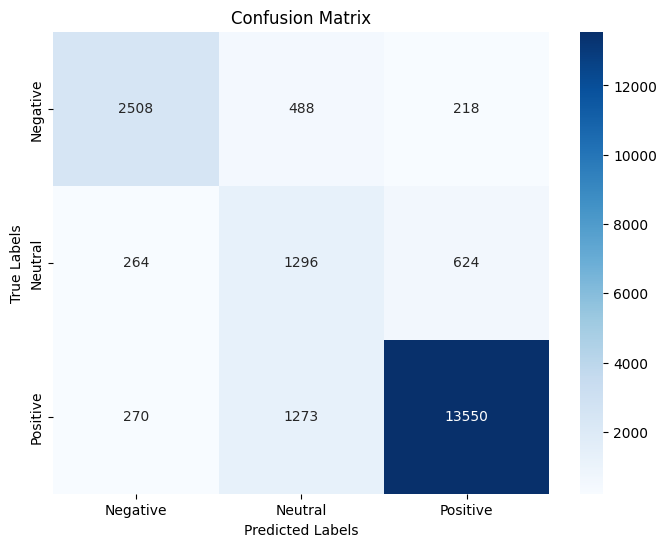


Running cross-validation for BiLSTM-Attention with WORD2VEC embeddings
Epoch 1/20, Loss: 0.5466, Accuracy: 0.7664
Epoch 2/20, Loss: 0.4880, Accuracy: 0.7971
Epoch 3/20, Loss: 0.4604, Accuracy: 0.8095
Epoch 4/20, Loss: 0.4311, Accuracy: 0.8251
Epoch 5/20, Loss: 0.3979, Accuracy: 0.8415
Epoch 6/20, Loss: 0.3615, Accuracy: 0.8595
Epoch 7/20, Loss: 0.3262, Accuracy: 0.8766
Epoch 8/20, Loss: 0.2911, Accuracy: 0.8905
Epoch 9/20, Loss: 0.2588, Accuracy: 0.9070
Epoch 10/20, Loss: 0.2283, Accuracy: 0.9202
Epoch 11/20, Loss: 0.1999, Accuracy: 0.9327
Epoch 12/20, Loss: 0.1732, Accuracy: 0.9438
Epoch 13/20, Loss: 0.1507, Accuracy: 0.9535
Epoch 14/20, Loss: 0.1291, Accuracy: 0.9604
Epoch 15/20, Loss: 0.1127, Accuracy: 0.9657
Epoch 16/20, Loss: 0.0955, Accuracy: 0.9716
Epoch 17/20, Loss: 0.0808, Accuracy: 0.9775
Epoch 18/20, Loss: 0.0673, Accuracy: 0.9818
Epoch 19/20, Loss: 0.0564, Accuracy: 0.9847
Epoch 20/20, Loss: 0.0478, Accuracy: 0.9874

Validation 1/5, Validation Accuracy: 0.7958
Epoch 1/20, 

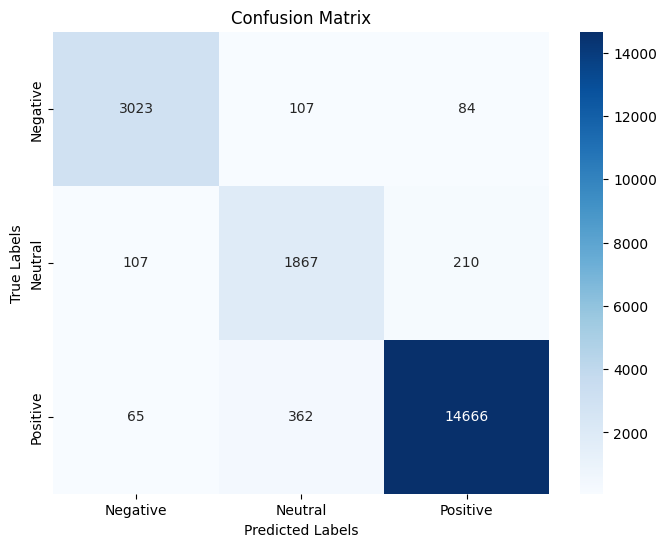


Running cross-validation for BiLSTM-Attention with DOC2VEC embeddings
Epoch 1/20, Loss: 0.5349, Accuracy: 0.7753
Epoch 2/20, Loss: 0.4804, Accuracy: 0.7983
Epoch 3/20, Loss: 0.4363, Accuracy: 0.8186
Epoch 4/20, Loss: 0.3530, Accuracy: 0.8614
Epoch 5/20, Loss: 0.2437, Accuracy: 0.9155
Epoch 6/20, Loss: 0.1496, Accuracy: 0.9538
Epoch 7/20, Loss: 0.0876, Accuracy: 0.9758
Epoch 8/20, Loss: 0.0488, Accuracy: 0.9885
Epoch 9/20, Loss: 0.0263, Accuracy: 0.9946
Epoch 10/20, Loss: 0.0133, Accuracy: 0.9982
Epoch 11/20, Loss: 0.0080, Accuracy: 0.9989
Epoch 12/20, Loss: 0.0054, Accuracy: 0.9993
Epoch 13/20, Loss: 0.0049, Accuracy: 0.9990
Epoch 14/20, Loss: 0.0032, Accuracy: 0.9994
Epoch 15/20, Loss: 0.0020, Accuracy: 0.9997
Epoch 16/20, Loss: 0.0043, Accuracy: 0.9990
Epoch 17/20, Loss: 0.0006, Accuracy: 1.0000
Epoch 18/20, Loss: 0.0028, Accuracy: 0.9991
Epoch 19/20, Loss: 0.0003, Accuracy: 1.0000
Epoch 20/20, Loss: 0.0031, Accuracy: 0.9989
Validation 1/5, Validation Accuracy: 0.8078

Epoch 1/20, L

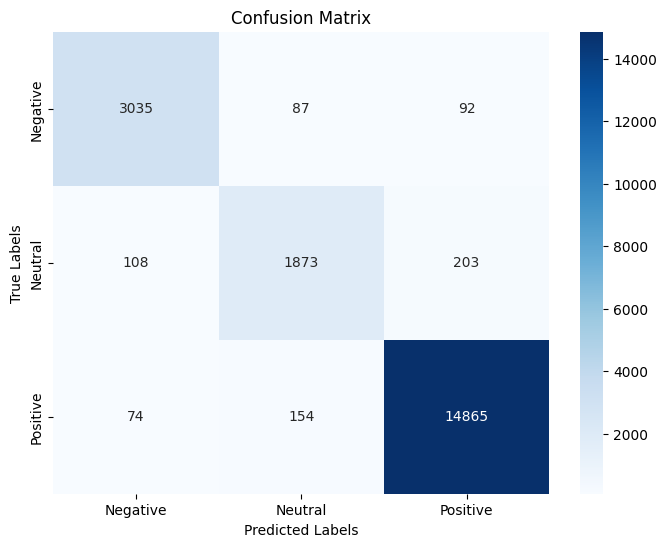

In [4]:
# Cross-validation and hyperparameter tuning for BiLSTM-Attention
def cross_validate_and_tune(vectors_type, labels, model_type='bilstm-attention', num_folds=5, num_epochs=20):
    skf = StratifiedKFold(n_splits=num_folds)
    best_model = None
    best_acc = 0.0

    for num_evaluation, (train_index, val_index) in enumerate(skf.split(vectors_type, labels)):
        X_train, X_val = vectors_type[train_index], vectors_type[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Apply SMOTE to the training data
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(pd.Categorical(y_train_smote).codes, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(pd.Categorical(y_val).codes, dtype=torch.long).to(device)

        # Define parameters
        input_size = X_train_tensor.shape[1]  # Embedding size (e.g., FastText, Word2Vec, etc.)
        hidden_size = 128
        output_size = len(np.unique(labels))  # Number of sentiment classes

        # Calculate class weights
        class_counts = Counter(y_train_smote)
        total_samples = len(y_train_smote)
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(device)

        # Create BiLSTM-Attention model instance
        bilstm_attention_model = SentimentBiLSTMWithAttention(input_size, hidden_size, output_size).to(device)

        # Define optimizer and loss function
        optimizer = optim.Adam(bilstm_attention_model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

        # Define DataLoader
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

        # Training loop
        def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct_predictions = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()

                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_acc = correct_predictions / len(train_loader.dataset)
                print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            return model

        # Train the model
        trained_model = train_model(bilstm_attention_model, train_loader, optimizer, loss_fn, num_epochs)

        # Evaluate the model
        def evaluate_model(model, X_val_tensor, y_val_tensor):
            model.eval()
            with torch.no_grad():
                outputs = model(X_val_tensor)
                acc = (outputs.argmax(dim=1) == y_val_tensor).sum().item() / len(y_val_tensor)
                cm = confusion_matrix(y_val_tensor.cpu(), outputs.argmax(dim=1).cpu())
                cr = classification_report(y_val_tensor.cpu(), outputs.argmax(dim=1).cpu(), target_names=['negative', 'neutral', 'positive'])
            return acc, cm, cr

        val_acc, val_cm, val_cr = evaluate_model(trained_model, X_val_tensor, y_val_tensor)
        print(f'Validation {num_evaluation + 1}/{num_folds}, Validation Accuracy: {val_acc:.4f} \n')


        if val_acc > best_acc:
            best_acc = val_acc
            best_model = trained_model

    return best_model, best_acc

# Final evaluation function
def final_evaluation(model, test_vectors_tensor, test_labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(test_vectors_tensor)
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == test_labels_tensor).sum().item() / len(test_labels_tensor)
        cm = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
        cr = classification_report(test_labels_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
    return acc, cm, cr

# Cross-validation and tuning for BiLSTM-Attention with different embedding types
labels = data['Sentiment'].values
vector_types = ["fasttext", "word2vec", "doc2vec"]

for vector_type in vector_types:
    print(f"\nRunning cross-validation for BiLSTM-Attention with {vector_type.upper()} embeddings")
    
    # Select the appropriate vectors for the cross-validation
    if vector_type == "fasttext":
        vectors = normalized_fasttext_vectors
    elif vector_type == "word2vec":
        vectors = normalized_word2vec_vectors
    elif vector_type == "doc2vec":
        vectors = normalized_doc2vec_vectors

    best_model, best_acc = cross_validate_and_tune(vectors_type=vectors, labels=labels, model_type='bilstm-attention', num_folds=5, num_epochs=20)
    print(f'Best BiLSTM-Attention model accuracy with {vector_type.upper()} embeddings: {best_acc:.4f}')

    # Select the appropriate vectors for the test set based on the vector_type
    if vector_type == "fasttext":
        vectors = normalized_fasttext_vectors
    elif vector_type == "word2vec":
        vectors = normalized_word2vec_vectors
    elif vector_type == "doc2vec":
        vectors = normalized_doc2vec_vectors

    # Convert test data to tensors
    test_vectors_tensor = torch.tensor(vectors, dtype=torch.float32).to(device)
    test_labels_tensor = torch.tensor(pd.Categorical(labels).codes, dtype=torch.long).to(device)

    # Final evaluation on test set
    final_acc, final_cm, final_cr = final_evaluation(best_model, test_vectors_tensor, test_labels_tensor)
    print(f"Final Test Accuracy: {final_acc:.4f}")
    print("Final Confusion Matrix:")
    print(final_cm)
    print("\nFinal Classification Report:")
    print(final_cr)

     # Define confusion_matrix
    def plot_confusion_matrix(cm, labels):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
        
    plot_confusion_matrix(final_cm, ['negative', 'neutral', 'positive'])

In [ ]:
# # Skip, will run all
# # Cross-validation and hyperparameter tuning for multiple models
# def cross_validate_and_tune(vectors_type, labels, model_type, num_folds=5, num_epochs=20):
#     # Select embedding vectors based on vectors_type
#     if vectors_type == "fasttext":
#         vectors = normalized_fasttext_vectors
#     elif vectors_type == "word2vec":
#         vectors = normalized_word2vec_vectors
#     elif vectors_type == "doc2vec":
#         vectors = normalized_doc2vec_vectors
#     else:
#         raise ValueError("Invalid vectors type. Choose 'fasttext', 'word2vec', or 'doc2vec'.")

#     skf = StratifiedKFold(n_splits=num_folds)
#     best_model = None
#     best_acc = 0.0

#     for num_evaluation, (train_index, val_index) in enumerate(skf.split(vectors, labels)):
#         X_train, X_val = vectors[train_index], vectors[val_index]
#         y_train, y_val = labels[train_index], labels[val_index]

#         # Apply SMOTE to the training data
#         smote = SMOTE(sampling_strategy='auto', random_state=42)
#         X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#         # Convert to tensors
#         X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32).to(device)
#         y_train_tensor = torch.tensor(pd.Categorical(y_train_smote).codes, dtype=torch.long).to(device)
#         X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
#         y_val_tensor = torch.tensor(pd.Categorical(y_val).codes, dtype=torch.long).to(device)

#         # Define parameters
#         input_size = 300
#         hidden_size = 128
#         output_size = len(set(labels))
#         num_layers = 2
#         dropout = 0.3
#         learning_rate = 0.001
        
#         # Calculate class weights
#         class_counts = Counter(y_train_smote)
#         total_samples = len(y_train_smote)
#         class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
#         class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(device)

#         # Initialize model based on model_type
#         if model_type == 'lstm':
#             model = SentimentLSTM(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout).to(device)
#         elif model_type == 'bilstm':
#             model = SentimentBiLSTM(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout).to(device)
#         elif model_type == 'bilstm-attention':
#             model = SentimentBiLSTMWithAttention(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout).to(device)
#         else:
#             raise ValueError("Invalid model type. Choose 'lstm', 'bilstm', or 'bilstm-attention'.")

#         # Define optimizer and loss function
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#         loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

#         # Define DataLoader
#         train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
#         train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

#         # Training loop
#         def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
#             for epoch in range(num_epochs):
#                 model.train()
#                 running_loss = 0.0
#                 correct_predictions = 0

#                 for inputs, labels in train_loader:
#                     inputs, labels = inputs.to(device), labels.to(device)

#                     optimizer.zero_grad()
#                     outputs = model(inputs)
#                     loss = loss_fn(outputs, labels)
#                     loss.backward()
#                     optimizer.step()

#                     running_loss += loss.item() * inputs.size(0)
#                     _, predicted = torch.max(outputs, 1)
#                     correct_predictions += (predicted == labels).sum().item()

#                 epoch_loss = running_loss / len(train_loader.dataset)
#                 epoch_acc = correct_predictions / len(train_loader.dataset)
#                 print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
#             return model

#         # Train the model
#         trained_model = train_model(model, train_loader, optimizer, loss_fn, num_epochs)

#         # Evaluate the model
#         def evaluate_model(model, X_val_tensor, y_val_tensor):
#             model.eval()
#             with torch.no_grad():
#                 outputs = model(X_val_tensor)
#                 _, predicted = torch.max(outputs, 1)
#                 acc = (predicted == y_val_tensor).sum().item() / len(y_val_tensor)
#                 cm = confusion_matrix(y_val_tensor.cpu(), predicted.cpu())
#                 cr = classification_report(y_val_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
#             return acc, cm, cr

#         # Perform evaluation on validation data
#         val_acc, val_cm, val_cr = evaluate_model(trained_model, X_val_tensor, y_val_tensor)
#         print(f'\nValidation Fold {num_evaluation + 1}/{num_folds}, Validation Accuracy: {val_acc:.4f}')

#         # Save the best model based on validation accuracy
#         if val_acc > best_acc:
#             best_acc = val_acc
#             best_model = trained_model

#     return best_model, best_acc

# # Perform cross-validation and get the best model
# labels = data['Sentiment'].values
# vector_types = ["fasttext", "word2vec", "doc2vec"]
# model_types = ["lstm", "bilstm", "bilstm-attention"]

# for vector_type in vector_types:
#     for model_type in model_types:
#         print(f"\nRunning cross-validation for {model_type.upper()} with {vector_type.upper()} embeddings")

#         best_model, best_acc = cross_validate_and_tune(vectors_type=vector_type, labels=labels, model_type=model_type, num_folds=5, num_epochs=20)
#         print(f'Best {model_type.upper()} model accuracy with {vector_type.upper()} embeddings: {best_acc:.4f}')

#         # Select the appropriate vectors for the test set based on the vector_type
#         if vector_type == "fasttext":
#             test_vectors = normalized_fasttext_vectors
#         elif vector_type == "word2vec":
#             test_vectors = normalized_word2vec_vectors
#         elif vector_type == "doc2vec":
#             test_vectors = normalized_doc2vec_vectors

#         # Convert test data to tensors
#         test_vectors_tensor = torch.tensor(test_vectors, dtype=torch.float32).to(device)
#         test_labels_tensor = torch.tensor(pd.Categorical(labels).codes, dtype=torch.long).to(device)

#         # Final evaluation on test set
#         def final_evaluation(model, test_vectors_tensor, test_labels_tensor):
#             model.eval()
#             with torch.no_grad():
#                 outputs = model(test_vectors_tensor)
#                 _, predicted = torch.max(outputs, 1)
#                 acc = (predicted == test_labels_tensor).sum().item() / len(test_labels_tensor)
#                 cm = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
#                 cr = classification_report(test_labels_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
#             return acc, cm, cr

#         # Evaluate the best model on the entire test set
#         final_acc, final_cm, final_cr = final_evaluation(best_model, test_vectors_tensor, test_labels_tensor)
#         print(f"Final Test Accuracy: {final_acc:.4f}")
#         print("Final Confusion Matrix:")
#         print(final_cm)
#         print("\nFinal Classification Report:")
#         print(final_cr)

#         # Confusion Matrix Visualization
#         def plot_confusion_matrix(cm, labels):
#             plt.figure(figsize=(8, 6))
#             sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
#             plt.xlabel('Predicted Label')
#             plt.ylabel('True Label')
#             plt.title('Confusion Matrix')
#             plt.show()

#         plot_confusion_matrix(final_cm, ['negative', 'neutral', 'positive'])
